<a href="https://colab.research.google.com/github/AarifCha/RAG-HF-Langchain/blob/main/HuggingFaceWLangchain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RAG setup on Google Drive with HuggingFace + LangChain
The goal of the notebook is to go over how to set up a RAG using an open-source HuggingFace model and LangChain. This only covers the basic setup with a vector store and a context-based (stuffed) Q/A LLM model. The expected type of documents in this notebook are pdf files from arXiv or other research publications.  


# Drive Mount and Installing Dependencies

First, we need to mount the drive and install the dependencies.

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install --quiet torch transformers sentence-transformers
!pip install --quiet langchain langchain_community
!pip install --quiet pypdf
!pip install --quiet chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 975.5/975.5 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.8/332.8 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 559.5/559.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [ ]:
# These are useful for formatting outputs
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import textwrap

def wrap_print(text):
    for line in textwrap.wrap(text):
        print(line)

# Q/A Model Setup

In this section we setup the LLM that will be later used for Q/A or to "chat with your data". Different models were tested, but we will be using arcee-ai's Arcee-Spark model (7B param) which claims to have out performed GPT3.5 on many tasks. This is a small model (but powerful) so we will be able to load it onto the GPU and greatly reduce the inference time.
Link to the model: https://huggingface.co/arcee-ai/Arcee-Spark

Note: While making this notebook A100 (40GB) GPU was used. If your GPU has less than 40GB of VRAM, you can comment out code that creates a quantized version of the model (float16). If GPU is not present, look at the notebook on using the pre-quantized GGUF file and llama-cpp-python to run inference on CPU.

In [ ]:
# Uncomment the following when using the quantized version.
#!pip install accelerate bitsandbytes

from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

In [ ]:
QA_MODEL_NAME = "arcee-ai/Arcee-Spark" #"bartowski/UNA-ThePitbull-21.4B-v2-GGUF"#"llmware/dragon-yi-6b-v0" #"HuggingFaceH4/zephyr-7b-beta"

# Uncomment the following lines to quantize the model before using it.
# bnb_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_use_double_quant=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_compute_dtype=torch.bfloat16,
# )
# QA_model = AutoModelForCausalLM.from_pretrained(
#     QA_MODEL_NAME, trust_remote_code=True, quantization_config=bnb_config).to('cuda')


# Comment this out while using the quantized version.
QA_model = AutoModelForCausalLM.from_pretrained(
    QA_MODEL_NAME, trust_remote_code=True ).to('cuda') # the .to('cuda') sets the device to GPU for the model.
QA_tokenizer = AutoTokenizer.from_pretrained(QA_MODEL_NAME)

# We will create a HuggingFace pipeline to do inference.
QA_LLM = pipeline(
    model=QA_model,
    tokenizer=QA_tokenizer,
    task="text-generation",
    temperature=None,
    top_p=None,
    top_k=None,
    do_sample=False, #We want greedy decoding to have a more focused generation.
    return_full_text=False,
    max_new_tokens=500,
    device = 0
)

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/27.8k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.33G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/367 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Now let's create a basic prompt and see the model in action. We will simply ask the bot to answer a question from a short context that we give ourselves. We will try two different contexts, one that doesn't contain the answer and one that does, and see if the model gives us the correct response.

In [ ]:
prompt_template = """<|im_start|>System:
You are a bot that answer questions based on the Context given to you.
Read the Context and tell the User if the answer is in the Context. ONLY answer what is asked in a concise but informative manner.
End the response with "Feel free to ask me more questions!". Make sure to stop any generation after "Feel free to ask me more questions!".
Example:
    [[<|im_start|>Context:
    There are 7 continents on Earth and they all start with the letter A.<|im_end|>
    <|im_start|>User:
    What is the capital of China?<im_end|>
    <|im_start|>assistant
    The answer to that question is not in the Context. Feel free to ask me more questions!<|im_end|>]]<|im_end|>
<|im_start|>Context:
{context}<|im_end|>
<|im_start|>User:
{question}<|im_end|>
<|im_start|>assistant:\n"""

# The system prompt tells the model its purpose and how it should go about performing that task.

context = """A generative adversarial network (GAN) is a deep learning architecture.
It trains two neural networks to compete against each other to generate more authentic new data from a given training dataset.
For instance, you can generate new images from an existing image database or original music from a database of songs."""

question = "Who is my best friend?"

final_prompt = prompt_template.format(context=context, question=question)

#Lets print and see what the final prompt looks like.
print(final_prompt)

<|im_start|>System:
You are a bot that answer questions based on the Context given to you.
Read the Context and tell the User if the answer is in the Context. ONLY answer what is asked in a concise but informative manner.
End the response with "Feel free to ask me more questions!". Make sure to stop any generation after "Feel free to ask me more questions!".
Example:
    [[<|im_start|>Context:
    There are 7 continents on Earth and they all start with the letter A.<|im_end|>
    <|im_start|>User:
    What is the capital of China?<im_end|>
    <|im_start|>assistant
    The answer to that question is not in the Context. Feel free to ask me more questions!<|im_end|>]]<|im_end|>
<|im_start|>Context:
A generative adversarial network (GAN) is a deep learning architecture.
It trains two neural networks to compete against each other to generate more authentic new data from a given training dataset.
For instance, you can generate new images from an existing image database or original music fro

Now we can pass this prompt to the pipeline and let the model generate an answer using the context. We expect it to tell us that the answer is not in the context.

In [ ]:
answer = QA_LLM(final_prompt)[0]['generated_text']
print(answer)

The answer to that question is not in the Context. Feel free to ask me more questions!


Perfect! Now let's try to give it some context that actually contains the answer to this question.

In [ ]:
context = """I am from Houston TX and I have a lot of friends. Probably about 100.
But it is really hard for me to choose a best friend (BF). But if I had to choose one, it would be John Doe.
He is a really nice guy and always helps me. He is also a very popular guy!"""

final_prompt = prompt_template.format(context=context, question=question)
answer = QA_LLM(final_prompt)[0]['generated_text']
print(answer)

Your best friend is John Doe. Feel free to ask me more questions!


Now try it yourself with your own context and question!

In [ ]:
context = """PUT YOUR CONTEXT HERE"""
question = """PUT YOUR QUESTION HERE"""

final_prompt = prompt_template.format(context=context, question=question)
answer = QA_LLM(final_prompt)[0]['generated_text']
print(answer)

PUT THE ANSWER BASED ON THE PROVIDED CONTEXT HERE. Feel free to ask me more questions!


# Vector Store using LangChain

In this section, we will focus on building a vector store using pdf files stored on the drive.

## Imports

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import WebBaseLoader

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Document Loading

### PDF from Drive

We use langChain's PyPDFLoader to load the file and convert it to text. It also creates metadata for the loaded document.

In [ ]:
loader = PyPDFLoader("/content/drive/MyDrive/Colab_Notebooks/NLP_Projects/Test_Docs/BERT.pdf") # Replace with your file path
BertPaper = loader.load()

In [ ]:
print(BertPaper[0].page_content[0:500])
print(BertPaper[0].metadata)

BERT: Pre-training of Deep Bidirectional Transformers for
Language Understanding
Jacob Devlin Ming-Wei Chang Kenton Lee Kristina Toutanova
Google AI Language
{jacobdevlin,mingweichang,kentonl,kristout }@google.com
Abstract
We introduce a new language representa-
tion model called BERT , which stands for
Bidirectional Encoder Representations from
Transformers. Unlike recent language repre-
sentation models (Peters et al., 2018a; Rad-
ford et al., 2018), BERT is designed to pre-
train deep bidirec
{'source': '/content/drive/MyDrive/Colab_Notebooks/NLP_Projects/Test_Docs/BERT.pdf', 'page': 0}


### From Website (Optional)

In [ ]:
loader = WebBaseLoader("https://aws.amazon.com/what-is/retrieval-augmented-generation/")
docs = loader.load()
for line in textwrap.wrap(docs[0].page_content[2500:3220]):
    print(line)

 Retrieval-Augmented Generation (RAG) is the process of optimizing the
output of a large language model, so it references an authoritative
knowledge base outside of its training data sources before generating
a response. Large Language Models (LLMs) are trained on vast volumes
of data and use billions of parameters to generate original output for
tasks like answering questions, translating languages, and completing
sentences. RAG extends the already powerful capabilities of LLMs to
specific domains or an organization's internal knowledge base, all
without the need to retrain the model. It is a cost-effective approach
to improving LLM output so it remains relevant, accurate, and useful
in various contexts.


## Vector Store

To create a vector store, we need to do two things. First,t we need to split the document into chunks. We do this by using langChain's recursiveCharacterTextSplitter. This recursively splits the documents using the separators given until the size of each split chunk is less than then chunk_size.

### Text-Splliting

Our model's max_seq_length is 512 tokens, so we want the chunks to be less than 512. But since we can estimate each token to be about the size of a word, we will set the chunk_size to just 512 and if any chunk is a little larger, truncation shouldn't result in much of a loss in embedding accuracy.

In [ ]:
EMBEDDING_MODEL_NAME = "mixedbread-ai/mxbai-embed-large-v1" #"sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)

SEPARATORS = [
    "\n\n",
    "\n",
    " ",
    ".",
    "?",
    "!",
    ",",
    ""
]

text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        tokenizer,
        chunk_size=512,
        chunk_overlap=50,
        add_start_index=True,
        strip_whitespace=True,
        separators=SEPARATORS,
    )

docs_processed = []
docs_processed += text_splitter.split_documents(BertPaper)

# Let us also add another
loader = PyPDFLoader("/content/drive/MyDrive/Colab_Notebooks/NLP_Projects/Test_Docs/GANs.pdf") # Replace with your file path
GANPaper = loader.load()

docs_processed += text_splitter.split_documents(GANPaper)

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

As a sanity check let's see the size of the chunks we have created

  0%|          | 0/81 [00:00<?, ?it/s]

Total number of chunks:  81


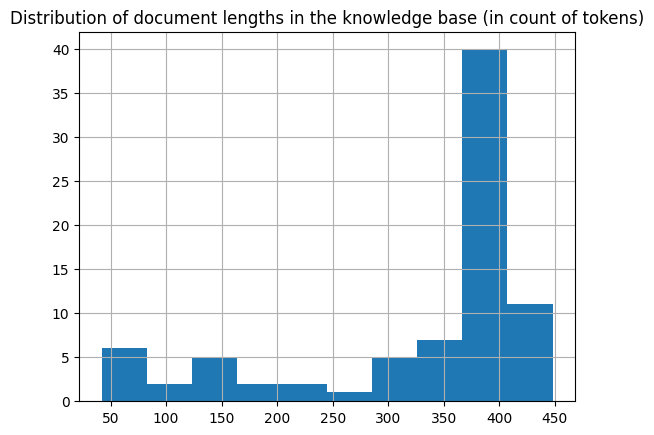

In [ ]:
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

# Plot the distribution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
print("Total number of chunks: ", len(docs_processed))
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

We see that the chunk sizes are actually smaller than 512 tokens.

### Vector Embedding and Vector Store

The second step is to create vector embeddings for those chunks using the embedding model and store both the chunks and their embedding vectors to create a vector store. Here, we will use Chroma to create our vector store, but one can use FAISS or Pinecone. But since we are just prototyping we don't need FAISS (efficient similarity search in large-scale applications) or Pinecone (enterprise-grade and secure)

In [ ]:
from langchain.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings

In [ ]:
embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

persist_directory = '/content/drive/MyDrive/Colab_Notebooks/NLP_Projects/chroma/' # Replace with your desired directory path
!rm -r /content/drive/MyDrive/Colab_Notebooks/NLP_Projects/chroma/*   # remove old database files if any

vectordb = Chroma(persist_directory=persist_directory, embedding_function=embedding_model)

vectordb = Chroma.from_documents(
    documents=docs_processed,
    embedding=embedding_model,
    persist_directory=persist_directory
)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/171 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/113k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

Now let's try to query from this database. We will embed a question we want to ask and then find a few chunks that might contain the answer to the question asked by finding chunks with embeddings that are the most similarity to the question embedding.

In [ ]:
user_query = "What is a BERT?"

print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = vectordb.similarity_search(user_query,k=3)

print("\n==================================Top document==================================")
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)
print(retrieved_docs[1].metadata)
print(retrieved_docs[2].metadata)


Starting retrieval for user_query='What is a BERT?'...

==================================Top document==================================
as natural language inference (Conneau et al.,
2017) and machine translation (McCann et al.,
2017). Computer vision research has also demon-
strated the importance of transfer learning from
large pre-trained models, where an effective recipe
is to ﬁne-tune models pre-trained with Ima-
geNet (Deng et al., 2009; Yosinski et al., 2014).
3 BERT
We introduce BERT and its detailed implementa-
tion in this section. There are two steps in our
framework: pre-training and ﬁne-tuning . Dur-
ing pre-training, the model is trained on unlabeled
data over different pre-training tasks. For ﬁne-
tuning, the BERT model is ﬁrst initialized with
the pre-trained parameters, and all of the param-
eters are ﬁne-tuned using labeled data from the
downstream tasks. Each downstream task has sep-
arate ﬁne-tuned models, even though they are ini-
tialized with the same pre-train

Let's try another one but focused on the other document

In [ ]:
user_query = "What is a GAN?"

print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = vectordb.similarity_search(user_query,k=3)

print("\n==================================Top document==================================")
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)
print(retrieved_docs[1].metadata)
print(retrieved_docs[2].metadata)


Starting retrieval for user_query='What is a GAN?'...

==================================Top document==================================
same ﬁxed point of the dynamics of GandDbut provides much stronger gradients early in learning.
x
z
X
Z
X
Z
. . .
X
Z
(a) (b) (c) (d)
Figure 1: Generative adversarial nets are trained by simultaneously updating the discriminative distribution
(D, blue, dashed line) so that it discriminates between samples from the data generating distribution (black,
dotted line)pxfrom those of the generative distribution pg(G) (green, solid line). The lower horizontal line is
the domain from which zis sampled, in this case uniformly. The horizontal line above is part of the domain
ofx. The upward arrows show how the mapping x=G(z)imposes the non-uniform distribution pgon
transformed samples. Gcontracts in regions of high density and expands in regions of low density of pg. (a)
Consider an adversarial pair near convergence: pgis similar to pdataandDis a partially accu

# Putting it all together

Now let us combine all these parts to create our RAG and wrap it in a method to do document-supported question-answering. We will first create a prompt template for this task.

### Prompt

We will use the QA model's chat template to create our RAG prompt template.

In [ ]:
# WE define 3 roles, System, Context, and User with the corresponding content.
# The final role for the bot will be inserted automatically by the apply_chat_template
prompt_in_chat_format = [
    {
        "role": "System:",
        "content": """You are a bot that answers a question asked by the User based on the Context given to you.
Read the Context and tell the User if the answer is in the Context. ONLY answer what is asked in a concise but informative manner.
Tell the User which Document number was most relevant in answering the question.
If the answer is not in the Context, tell the User that the answer is not in the Context and that none of the Documents were relevant.
End the response with "Feel free to ask me more questions!". Make sure to stop any generation after "Feel free to ask me more questions!".
Example:
    [[<|im_start|>Context:
    Document 0: There are 7 continents on Earth and they all start with the letter A.<|im_end|>
    <|im_start|>User:
    What is the capital of China?<im_end|>
    <|im_start|>assistant
    The answer to that question is not in the Context. None of the Documents were relevant. Feel free to ask me more questions!<|im_end|>]]""",
    },
    {
        "role": "Context:",
        "content": """{context}""",
    },
    {
        "role": "User:",
        "content": "{question}",
    }
]

RAG_PROMPT_TEMPLATE = QA_tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True)

# Let's print and see what the template looks like
print(RAG_PROMPT_TEMPLATE)

<|im_start|>System:
You are a bot that answers a question asked by the User based on the Context given to you.
Read the Context and tell the User if the answer is in the Context. ONLY answer what is asked in a concise but informative manner.
Tell the User which Document number was most relevant in answering the question.
If the answer is not in the Context, tell the User that the answer is not in the Context and that none of the Documents were relevant.
End the response with "Feel free to ask me more questions!". Make sure to stop any generation after "Feel free to ask me more questions!".
Example:
    [[<|im_start|>Context:
    Document 0: There are 7 continents on Earth and they all start with the letter A.<|im_end|>
    <|im_start|>User:
    What is the capital of China?<im_end|>
    <|im_start|>assistant
    The answer to that question is not in the Context. None of the Documents were relevant. Feel free to ask me more questions!<|im_end|>]]<|im_end|>
<|im_start|>Context:
{context}

Now let us define a method to get a context string and then a method that returns the response given a question and number of context docs to use.

In [ ]:
def get_context(query: str, k: int = 3):
    """
    This function gets k most relevant documents for a given query
    and concatenates their content into a single string.

    Args:
        query (str): The query to search for.
        k (int): The number of documents to retrieve.

    Returns:
        str: A string containing the concatenated content of the retrieved documents.
    """

    retrieved_docs = vectordb.similarity_search(query,k=k)
    retrieved_docs_text = [doc.page_content for doc in retrieved_docs] # Get only the page content

    context = ""
    context += "".join(
        [f"Document {i}: "+doc+"\n" for i, doc in enumerate(retrieved_docs_text)])

    return context

def QA_answer(query: str, k: int = 3):
    """
    This function returns an answer to a query using the QA LLM pipeline and context
    provided by the get_context method.

    Args:
        query (str): The query to answer.
        k (int): The number of documents to retrieve.

    Returns:
        str: The answer to the query.
    """

    doc_context = get_context(query, k)

    final_prompt = RAG_PROMPT_TEMPLATE.format(
        question=query, context=doc_context)

    answer = QA_LLM(final_prompt)[0]["generated_text"]

    return answer

Now let us see how this performs! Let's ask it about questions from the two documents we provided.

In [ ]:
wrap_print(QA_answer("What is a GAN?"))

A Generative Adversarial Network (GAN) is a type of machine learning
model that uses two neural networks, a generator (G) and a
discriminator (D), to generate new data that resembles the training
data. The generator creates new data instances, while the
discriminator evaluates them for authenticity; i.e., whether they look
like the training data or not. The two networks are trained together
in a zero-sum game, where the generator tries to fool the
discriminator into thinking its generated data is real, and the
discriminator tries to distinguish real data from fake data. This
process leads to the generator improving its ability to create
realistic data.  Document number: 0


In [ ]:
wrap_print(QA_answer("What is BERT?"))

The answer to your question is in Document 1. BERT stands for
Bidirectional Encoder Representations from Transformers. It is a new
language representation model designed to pre-train deep bidirectional
representations from unlabeled text by jointly conditioning on both
left and right context in all layers.  Document Number: 1


Our RAG is working exactly as expected! Now try a question that can not be answered from the documents provided

In [ ]:
wrap_print(QA_answer("What is a GNN?"))

The answer to that question is not in the Context. None of the
Documents were relevant.  Feel free to ask me more questions!


Try your own question!

In [ ]:
question = """PUT YOUR QUESTION HERE"""
wrap_print(QA_answer(question))

The answer to your question is not in the provided Context. Feel free
to ask me more questions!
